## GET AMPLITUDE PLOTS 
### - Using CN0 values 
####     -- MeasEpoch2 block: 1s
### - T=0.5m (max & min values of 1m interval)
### - df is in ISMR format 
### - Processing time efficient
### - Elevation data is included
####     -- Channel Status block: 10s

### 1) Read csv file

In [248]:
import pandas as pd
import math as mt
import datetime
import matplotlib.pyplot as plt
import numpy as np
import time 

start = time.time()

In [249]:
!ls -lthr ../data/

total 1,2G
-rw-r--r-- 1 luis luis 1,1G may 21 10:03 ljic3240.20__SBF_IQCorr_1.txt
-rw-r--r-- 1 luis luis  20M may 21 11:07 ljic3250.20__SBF_IQCorr.txt
-rw-r--r-- 1 luis luis  23M may 21 16:59 ljic3240.20__SBF_IQCorr_2.txt
-rw-r--r-- 1 luis luis  69K jun  3 16:06 ljic1280.21__SBF_ChannelStatus.txt
-rw-r--r-- 1 luis luis 3,5M jun  3 16:30 ljic3240.20__SBF_ChannelStatus.txt
-rw-r--r-- 1 luis luis  51M jun  4 18:27 ljic3240.20__SBF_MeasEpoch2.txt


In [250]:
root_path = "/home/luis/Desktop/Proyects_Files/LISN/GPSs/Tareas/Graficas_desvanecimientos/other/lower_sampling/"
input_files_path = root_path + "data/"
input_file_cn = input_files_path + "ljic3240.20__SBF_MeasEpoch2.txt"
input_file_elv = input_files_path + "ljic3240.20__SBF_ChannelStatus.txt"

### 1.1) Read CN0 file

In [251]:
df_cn = pd.read_csv(input_file_cn,skiprows=[0,1,2,3,5], usecols=[0,1,9,11,17])
df_cn.head()

,TOW [s],WNc [w],SVID,MeasType,CN0_dBHz [dB-Hz]
0,351000.0,2132,G27,GPS_L5,44.00
1,351000.0,2132,G27,GPS_L1CA,39.25
2,351000.0,2132,G27,GPS_L2PY,22.75
3,351000.0,2132,G27,GPS_L2C,40.25
4,351000.0,2132,G27,GPS_L1PY,22.75


In [252]:
df_cn.rename(columns={"MeasType":"Signal", "CN0_dBHz [dB-Hz]":"CN0"}, inplace=True)
df_cn.head()

,TOW [s],WNc [w],SVID,Signal,CN0
0,351000.0,2132,G27,GPS_L5,44.00
1,351000.0,2132,G27,GPS_L1CA,39.25
2,351000.0,2132,G27,GPS_L2PY,22.75
3,351000.0,2132,G27,GPS_L2C,40.25
4,351000.0,2132,G27,GPS_L1PY,22.75


In [253]:
df_cn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390021 entries, 0 to 390020
Data columns (total 5 columns):
TOW [s]    390021 non-null float64
WNc [w]    390021 non-null int64
SVID       390021 non-null object
Signal     390021 non-null object
CN0        390021 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 14.9+ MB


### 1.2) Read Elevation file

In [254]:
df_elv = pd.read_csv(input_file_elv, skiprows=[0,1,2,3,5], usecols=[0,1,2,14])
df_elv.head()

,TOW [s],WNc [w],SVID,Elevation [°]
0,351000.0,2132,G27,15.0
1,351000.0,2132,G08,47.0
2,351000.0,2132,G31,13.0
3,351000.0,2132,G04,69.0
4,351000.0,2132,G22,38.0


In [255]:
# Rename elevation column
df_elv.rename(columns={"Elevation [°]":"Elev"}, inplace=True)
df_elv.head()

,TOW [s],WNc [w],SVID,Elev
0,351000.0,2132,G27,15.0
1,351000.0,2132,G08,47.0
2,351000.0,2132,G31,13.0
3,351000.0,2132,G04,69.0
4,351000.0,2132,G22,38.0


In [256]:
df_elv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17424 entries, 0 to 17423
Data columns (total 4 columns):
TOW [s]    17424 non-null float64
WNc [w]    17424 non-null int64
SVID       17424 non-null object
Elev       15057 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 544.6+ KB


### 1.3) Join dfs

In [259]:
df = df_cn.merge(df_elv, how="left", on=["TOW [s]", "WNc [w]", "SVID"])
df.head()

,TOW [s],WNc [w],SVID,Signal,CN0,Elev
0,351000.0,2132,G27,GPS_L5,44.00,15.0
1,351000.0,2132,G27,GPS_L1CA,39.25,15.0
2,351000.0,2132,G27,GPS_L2PY,22.75,15.0
3,351000.0,2132,G27,GPS_L2C,40.25,15.0
4,351000.0,2132,G27,GPS_L1PY,22.75,15.0


## 2) Change format

### 2.1) Change freq_code (GPS_L1CA) to sig code (Sig1)

In [262]:
# Reassign values in "Signal" column with 3 unique values 
# OJO: Only GPS, GALILEO & SBAS constellations are considered in
#      order to save time. Uncomment another constellation
#      if you need it. 
def get_CN0code(signal):
    signal = signal.split("_")
    const = signal[0]
    try: 
        freq = signal[1]
    except LookupError:
        return np.nan
    #
    if const == "GPS":
        if freq == "L1CA": return "Sig1"
        elif freq == "L2C": return "Sig2"
        elif freq == "L5": return "Sig3"
        else: return np.nan
    elif const == "GAL":
        if freq == "L1BC": return "Sig1"
        elif freq == "E5a": return "Sig2"
        elif freq == "E5b": return "Sig3"
        else: return np.nan
    #elif const == "GLO":
    #    if freq == "L1CA": return "Sig1"
    #    elif freq == "L2C": return "Sig2"
    #    else: return np.nan
    #elif const == "BDS": 
    #    if freq == "B1": return "Sig1"
    #    elif freq == "B2": return "Sig2"
    #    elif freq == "B3": return "Sig3"
    #    else: return np.nan
    elif const == "GEO": # SBAS
        if freq == "L1CA": return "Sig1"
        elif freq == "L5": return "Sig2"
        else: return np.nan
    #elif const == "QZS": # const name might change, verify!
    #    if freq == "L1CA": return "Sig1"
    #    elif freq == "L2C": return "Sig2"
    #    elif freq == "L5": return "Sig3"
    #    else: return np.nan
    #elif const == "IRN": # const name might change, verify!
    #    if freq == "B1": return "Sig1"
    #    else: return np.nan
    else: return np.nan

In [263]:
df["Signal"] = df["Signal"].astype(str).apply(get_CN0code)

In [264]:
df.head()

,TOW [s],WNc [w],SVID,Signal,CN0,Elev
0,351000.0,2132,G27,Sig3,44.00,15.0
1,351000.0,2132,G27,Sig1,39.25,15.0
2,351000.0,2132,G27,NaN,22.75,15.0
3,351000.0,2132,G27,Sig2,40.25,15.0
4,351000.0,2132,G27,NaN,22.75,15.0


In [266]:
# drop nan values in "Signal" column
df.dropna(subset=["Signal"], inplace=True)

In [267]:
df.head()

,TOW [s],WNc [w],SVID,Signal,CN0,Elev
0,351000.0,2132,G27,Sig3,44.00,15.0
1,351000.0,2132,G27,Sig1,39.25,15.0
3,351000.0,2132,G27,Sig2,40.25,15.0
5,351000.0,2132,G08,Sig3,48.25,47.0
6,351000.0,2132,G08,Sig1,46.75,47.0


### 2.2) Convert GPS to UTC time

In [270]:
# Convert GPS to UTC time
def GPS2UTCtime(row):
    leapseconds = 0 # change
    gpsseconds = int(row[0])
    gpsweek = int(row[1])

    datetimeformat = "%Y-%m-%d %H:%M:%S"
    first_epoch = datetime.datetime.strptime("1980-01-06 00:00:00",datetimeformat)
    elapsed = datetime.timedelta(days=(gpsweek*7),seconds=(gpsseconds-leapseconds))
    
    return first_epoch + elapsed

In [271]:
newDate = df.iloc[:,[0,1]].apply(GPS2UTCtime, axis=1)
# Create new column at position 0
df.insert(0, column="DateTime",value=newDate)
del df["TOW [s]"]
del df["WNc [w]"]
# Set DateTime column as index 
df.set_index("DateTime", inplace=True)

In [272]:
df.head()

,SVID,Signal,CN0,Elev
DateTime,,,,
2020-11-19 01:30:00,G27,Sig3,44.00,15.0
2020-11-19 01:30:00,G27,Sig1,39.25,15.0
2020-11-19 01:30:00,G27,Sig2,40.25,15.0
2020-11-19 01:30:00,G08,Sig3,48.25,47.0
2020-11-19 01:30:00,G08,Sig1,46.75,47.0


### 2.3) Decimate: 2 samples per minute

In [274]:
df2 = df.reset_index().set_index(['SVID', 'Signal', 'DateTime']).sort_index()
df2.head()

CN0  Elev
SVID Signal DateTime                        
E07  Sig1   2020-11-19 01:30:00  49.00  70.0
            2020-11-19 01:30:01  50.00   NaN
            2020-11-19 01:30:02  50.25   NaN
            2020-11-19 01:30:03  49.75   NaN
            2020-11-19 01:30:04  49.75   NaN

In [275]:
# OJO: Due to the fact that there are only 10s elev data,
#      min/max elev info is calculated, to approximate to 
#      a real scenario. 
level_values = df2.index.get_level_values
df3 = (df2.groupby([level_values(i) for i in [0,1]]
                      +[pd.Grouper(freq='T', level=-1)]).agg(["min", "max"]))
df3.head()

CN0         Elev      
                                   min    max   min   max
SVID Signal DateTime                                     
E07  Sig1   2020-11-19 01:30:00  48.00  51.00  70.0  70.0
            2020-11-19 01:31:00  47.75  50.50  69.0  70.0
            2020-11-19 01:32:00  48.25  50.00  69.0  69.0
            2020-11-19 01:33:00  48.25  50.25  69.0  69.0
            2020-11-19 01:34:00  47.75  50.25  68.0  69.0

OPTIONAL-----------START

In [276]:
# Optional approach.-
# Elevation values correspond to the mi/max 'Amp' values
# This could be useful if there would be 1Hz elevation data

def func(x):
    amp_max = x["Amp"].max()
    index_max = x["Amp"].idxmax(axis=0) # index of max value 
    elev_max = x.loc[index_max, "Elev"]
    
    amp_min = x["Amp"].min()
    index_min = x["Amp"].idxmin(axis=0) # index of max value 
    elev_min = x.loc[index_min, "Elev"]
    
    return pd.Series([elev_min, elev_max, amp_min, amp_max], index=["Elev_min", "Elev_max", "Amp_min", "Amp_max"])

In [277]:
level_values = df2.index.get_level_values
df3_aux = (df2.groupby([level_values(i) for i in [0,1]]
                      +[pd.Grouper(freq='T', level=-1)]).apply(func))
df3_aux.head()

KeyError: 'Amp'

-----------------END 

In [278]:
df3.columns

MultiIndex(levels=[['CN0', 'Elev'], ['min', 'max']],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]])

In [279]:
# Flatten and rename columns 
index1 = df3.columns.get_level_values(0)
index2 = df3.columns.get_level_values(1)

new_columns = []
for i in range(4):
    value = index1[i] + "_" + index2[i]
    new_columns.append(value)
new_columns

['CN0_min', 'CN0_max', 'Elev_min', 'Elev_max']

In [280]:
df3.columns = new_columns
df3.head()

CN0_min  CN0_max  Elev_min  Elev_max
SVID Signal DateTime                                                 
E07  Sig1   2020-11-19 01:30:00    48.00    51.00      70.0      70.0
            2020-11-19 01:31:00    47.75    50.50      69.0      70.0
            2020-11-19 01:32:00    48.25    50.00      69.0      69.0
            2020-11-19 01:33:00    48.25    50.25      69.0      69.0
            2020-11-19 01:34:00    47.75    50.25      68.0      69.0

In [281]:
# Reset index 
df4 = df3.reset_index().set_index("DateTime").sort_index()
df4.head(3)

,SVID,Signal,CN0_min,CN0_max,Elev_min,Elev_max
DateTime,,,,,,
2020-11-19 01:30:00,E07,Sig1,48.00,51.00,70.0,70.0
2020-11-19 01:30:00,G09,Sig2,42.50,43.25,30.0,30.0
2020-11-19 01:30:00,G09,Sig3,46.25,46.75,30.0,30.0


In [282]:
# Merge min & max values in a single column, and decrease the T=30s
# min
df_min = df4.iloc[:,[0,1,2,4]]
df_min.rename(columns={"CN0_min":"CN0", "Elev_min": "Elev"}, inplace = True)
df_min.head(3)

/home/luis/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,SVID,Signal,CN0,Elev
DateTime,,,,
2020-11-19 01:30:00,E07,Sig1,48.00,70.0
2020-11-19 01:30:00,G09,Sig2,42.50,30.0
2020-11-19 01:30:00,G09,Sig3,46.25,30.0


In [283]:
# max
df_max = df4.iloc[:,[0,1,3,5]]
df_max.rename(columns={"CN0_max":"CN0", "Elev_max": "Elev"}, inplace = True)
df_max.head(3)

,SVID,Signal,CN0,Elev
DateTime,,,,
2020-11-19 01:30:00,E07,Sig1,51.00,70.0
2020-11-19 01:30:00,G09,Sig2,43.25,30.0
2020-11-19 01:30:00,G09,Sig3,46.75,30.0


In [284]:
# Add 30s to the index 
df_max.index += datetime.timedelta(seconds=30)
df_max.head(3)

,SVID,Signal,CN0,Elev
DateTime,,,,
2020-11-19 01:30:30,E07,Sig1,51.00,70.0
2020-11-19 01:30:30,G09,Sig2,43.25,30.0
2020-11-19 01:30:30,G09,Sig3,46.75,30.0


In [285]:
df5 = pd.concat([df_min, df_max])
df5.sort_index(inplace=True)
df5.head()

,SVID,Signal,CN0,Elev
DateTime,,,,
2020-11-19 01:30:00,E07,Sig1,48.00,70.0
2020-11-19 01:30:00,G01,Sig3,51.00,49.0
2020-11-19 01:30:00,E26,Sig3,45.75,35.0
2020-11-19 01:30:00,G03,Sig1,44.75,38.0
2020-11-19 01:30:00,E26,Sig2,45.00,35.0


In [286]:
df5.sort_values(by=["SVID","Signal"]).head()

,SVID,Signal,CN0,Elev
DateTime,,,,
2020-11-19 01:30:00,E07,Sig1,48.00,70.0
2020-11-19 01:30:30,E07,Sig1,51.00,70.0
2020-11-19 01:31:00,E07,Sig1,47.75,69.0
2020-11-19 01:31:30,E07,Sig1,50.50,70.0
2020-11-19 01:32:00,E07,Sig1,48.25,69.0


### 2.4) Divide 'Signal' columns into three columns: "CN0_sig1", "CN0_sig2", "CNO_sig3" 

In [289]:
# Reindex 
df6 = df5.reset_index().set_index(['DateTime', 'SVID', 'Signal']).sort_index()
df6.head()

CN0  Elev
DateTime            SVID Signal             
2020-11-19 01:30:00 E07  Sig1    48.00  70.0
                         Sig2    49.00  70.0
                         Sig3    49.75  70.0
                    E08  Sig1    38.25  25.0
                         Sig2    40.00  25.0

In [290]:
# Unstack 
df6 = df6.unstack(level=-1)
df6.head()

CN0                Elev            
Signal                     Sig1   Sig2   Sig3  Sig1  Sig2  Sig3
DateTime            SVID                                       
2020-11-19 01:30:00 E07   48.00  49.00  49.75  70.0  70.0  70.0
                    E08   38.25  40.00  41.25  25.0  25.0  25.0
                    E13   48.00  48.75  50.00  65.0  65.0  65.0
                    E15   37.75  41.50  42.00  26.0  26.0  26.0
                    E26   43.50  45.00  45.75  35.0  35.0  35.0

In [291]:
#df6.columns = df6.columns.droplevel()
#df6.head()

In [292]:
# Separate 
df6 = df6.reset_index()
df6.head()

DateTime SVID    CN0                Elev            
Signal                            Sig1   Sig2   Sig3  Sig1  Sig2  Sig3
0      2020-11-19 01:30:00  E07  48.00  49.00  49.75  70.0  70.0  70.0
1      2020-11-19 01:30:00  E08  38.25  40.00  41.25  25.0  25.0  25.0
2      2020-11-19 01:30:00  E13  48.00  48.75  50.00  65.0  65.0  65.0
3      2020-11-19 01:30:00  E15  37.75  41.50  42.00  26.0  26.0  26.0
4      2020-11-19 01:30:00  E26  43.50  45.00  45.75  35.0  35.0  35.0

In [293]:
df6.set_index("DateTime", inplace=True)
df6.head()

SVID    CN0                Elev            
Signal                     Sig1   Sig2   Sig3  Sig1  Sig2  Sig3
DateTime                                                       
2020-11-19 01:30:00  E07  48.00  49.00  49.75  70.0  70.0  70.0
2020-11-19 01:30:00  E08  38.25  40.00  41.25  25.0  25.0  25.0
2020-11-19 01:30:00  E13  48.00  48.75  50.00  65.0  65.0  65.0
2020-11-19 01:30:00  E15  37.75  41.50  42.00  26.0  26.0  26.0
2020-11-19 01:30:00  E26  43.50  45.00  45.75  35.0  35.0  35.0

In [294]:
# Select the min elevation value
df6["Elev_"] = df6["Elev"].apply(lambda x: np.nanmin(x), axis=1)

In [295]:
del df6[("Elev","Sig1")]
del df6[("Elev","Sig2")]
del df6[("Elev","Sig3")]

In [296]:
df6.head()

SVID    CN0               Elev_
Signal                     Sig1   Sig2   Sig3      
DateTime                                           
2020-11-19 01:30:00  E07  48.00  49.00  49.75  70.0
2020-11-19 01:30:00  E08  38.25  40.00  41.25  25.0
2020-11-19 01:30:00  E13  48.00  48.75  50.00  65.0
2020-11-19 01:30:00  E15  37.75  41.50  42.00  26.0
2020-11-19 01:30:00  E26  43.50  45.00  45.75  35.0

In [297]:
df6.set_axis(["PRN", "CN0_sig1", "CN0_sig2", "CN0_sig3", "Elev"], axis=1)
df6.head()

/home/luis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  """Entry point for launching an IPython kernel.


,PRN,CN0_sig1,CN0_sig2,CN0_sig3,Elev
DateTime,,,,,
2020-11-19 01:30:00,E07,48.00,49.00,49.75,70.0
2020-11-19 01:30:00,E08,38.25,40.00,41.25,25.0
2020-11-19 01:30:00,E13,48.00,48.75,50.00,65.0
2020-11-19 01:30:00,E15,37.75,41.50,42.00,26.0
2020-11-19 01:30:00,E26,43.50,45.00,45.75,35.0


In [298]:
# Sort values by "PRN"
df6 = df6.reset_index().sort_values(by=["PRN", "DateTime"]).set_index("DateTime")
df6.head()

,PRN,CN0_sig1,CN0_sig2,CN0_sig3,Elev
DateTime,,,,,
2020-11-19 01:30:00,E07,48.00,49.00,49.75,70.0
2020-11-19 01:30:30,E07,51.00,53.50,54.00,70.0
2020-11-19 01:31:00,E07,47.75,48.75,50.00,69.0
2020-11-19 01:31:30,E07,50.50,52.75,53.75,70.0
2020-11-19 01:32:00,E07,48.25,49.50,50.25,69.0


In [299]:
# Reorder columns 
columnsTitles = ['PRN', 'Elev', 'CN0_sig1', 'CN0_sig2','CN0_sig3']
df6 = df6.reindex(columns=columnsTitles)
df6.head()

,PRN,Elev,CN0_sig1,CN0_sig2,CN0_sig3
DateTime,,,,,
2020-11-19 01:30:00,E07,70.0,48.00,49.00,49.75
2020-11-19 01:30:30,E07,70.0,51.00,53.50,54.00
2020-11-19 01:31:00,E07,69.0,47.75,48.75,50.00
2020-11-19 01:31:30,E07,70.0,50.50,52.75,53.75
2020-11-19 01:32:00,E07,69.0,48.25,49.50,50.25


### 3. Plot 

In [306]:
mask = df6["PRN"]=="S138"
df_plot = df6[mask]
df_plot.head()

,PRN,Elev,CN0_sig1,CN0_sig2,CN0_sig3
DateTime,,,,,
2020-11-19 01:30:00,S138,52.0,NaN,51.00,NaN
2020-11-19 01:30:30,S138,52.0,NaN,54.25,NaN
2020-11-19 01:31:00,S138,52.0,NaN,50.00,NaN
2020-11-19 01:31:30,S138,52.0,NaN,54.00,NaN
2020-11-19 01:32:00,S138,52.0,NaN,49.75,NaN


Text(0.5, 1.0, 'Signal Intensity')

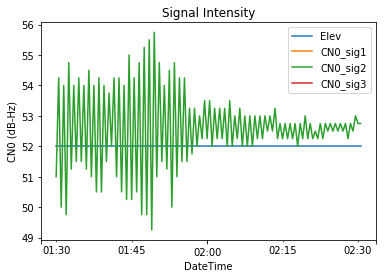

In [307]:
df_plot.plot()
plt.ylabel("CN0 (dB-Hz)")
plt.title("Signal Intensity")

In [303]:
end = time.time()
print(f"{end - start} s")

31.21772336959839 s
